# Variational Auto-Encoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Loading the MNIST Dataset

In [2]:
BATCH_SIZE = 100
epochs = 10

# MNIST Dataset
train_dataset = datasets.MNIST(root="./mnist_data/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="./mnist_data/", train=False, transform=transforms.ToTensor(), download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### VAE Class

In [3]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, x_dim, h_dim_1, h_dim_2, z_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim_1)
        self.fc2 = nn.Linear(h_dim_1, h_dim_2)
        self.fc31 = nn.Linear(h_dim_2, z_dim)
        self.fc32 = nn.Linear(h_dim_2, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim_2)
        self.fc5 = nn.Linear(h_dim_2, h_dim_1)
        self.fc6 = nn.Linear(h_dim_1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [4]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoEncoder(28*28, 512, 256, 2).to(dev)
optimiser = optim.Adam(vae.parameters())

def loss_function(recon_x, x, mu, log_var, use_recon_loss=True, use_kl_loss=True):
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum") if use_recon_loss else 0
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) if use_kl_loss else 0
    return BCE + KLD

def train(epoch, use_recon_loss=True, use_kl_loss=True):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(dev)
        optimiser.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var, use_recon_loss, use_kl_loss)
        loss.backward()
        train_loss += loss.item()
        optimiser.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]	Loss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

def visualize_latent_space():
    vae.eval()
    z_list, labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(dev)
            _, mu, _ = vae(data)
            z_list.append(mu.cpu().numpy())
            labels.append(target.numpy())
    z = np.concatenate(z_list, axis=0)
    labels = np.concatenate(labels, axis=0)
    plt.figure(figsize=(8, 6))
    plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.title("Latent Space Visualization")
    plt.show()

def sample_and_generate(grid_size=20):
    vae.eval()
    grid_x = np.linspace(-3, 3, grid_size)
    grid_y = np.linspace(-3, 3, grid_size)
    samples = []
    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                z = torch.tensor([[grid_x[i], grid_y[j]]], dtype=torch.float).to(dev)
                sample = vae.decoder(z).cpu().view(28, 28).numpy()
                samples.append(sample)
    grid_image = np.concatenate([np.concatenate(samples[i * grid_size:(i + 1) * grid_size], axis=1) for i in range(grid_size)], axis=0)
    plt.imshow(grid_image, cmap="gray")
    plt.title("Generated Digits from 2D Grid")
    plt.axis("off")
    plt.show()

Train Epoch: 1 [0/60000]	Loss: 543.486602
Train Epoch: 1 [10000/60000]	Loss: 191.973047
Train Epoch: 1 [20000/60000]	Loss: 177.176348
Train Epoch: 1 [30000/60000]	Loss: 162.073994
Train Epoch: 1 [40000/60000]	Loss: 156.778389
Train Epoch: 1 [50000/60000]	Loss: 162.245459
====> Epoch: 1 Average loss: 178.0803
Train Epoch: 2 [0/60000]	Loss: 160.909531
Train Epoch: 2 [10000/60000]	Loss: 163.103350
Train Epoch: 2 [20000/60000]	Loss: 165.373086
Train Epoch: 2 [30000/60000]	Loss: 167.797734
Train Epoch: 2 [40000/60000]	Loss: 153.011387
Train Epoch: 2 [50000/60000]	Loss: 161.424238
====> Epoch: 2 Average loss: 157.8753
Train Epoch: 3 [0/60000]	Loss: 148.527207
Train Epoch: 3 [10000/60000]	Loss: 153.832754
Train Epoch: 3 [20000/60000]	Loss: 157.358340
Train Epoch: 3 [30000/60000]	Loss: 144.119551
Train Epoch: 3 [40000/60000]	Loss: 149.143281
Train Epoch: 3 [50000/60000]	Loss: 151.536689
====> Epoch: 3 Average loss: 152.3423
Train Epoch: 4 [0/60000]	Loss: 159.127588
Train Epoch: 4 [10000/60000]

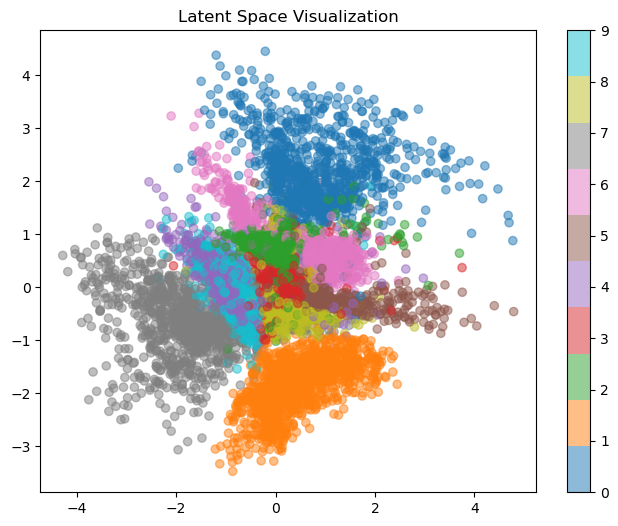

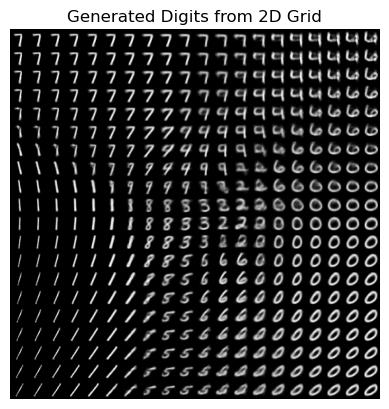

Train Epoch: 1 [0/60000]	Loss: 6.327655
Train Epoch: 1 [10000/60000]	Loss: 0.108645
Train Epoch: 1 [20000/60000]	Loss: 0.036710
Train Epoch: 1 [30000/60000]	Loss: 0.019385
Train Epoch: 1 [40000/60000]	Loss: 0.011876
Train Epoch: 1 [50000/60000]	Loss: 0.010258
====> Epoch: 1 Average loss: 0.2282
Train Epoch: 2 [0/60000]	Loss: 0.009057
Train Epoch: 2 [10000/60000]	Loss: 0.008076
Train Epoch: 2 [20000/60000]	Loss: 0.007186
Train Epoch: 2 [30000/60000]	Loss: 0.007400
Train Epoch: 2 [40000/60000]	Loss: 0.008522
Train Epoch: 2 [50000/60000]	Loss: 0.006269
====> Epoch: 2 Average loss: 0.0077
Train Epoch: 3 [0/60000]	Loss: 0.005389
Train Epoch: 3 [10000/60000]	Loss: 0.004763
Train Epoch: 3 [20000/60000]	Loss: 0.005363
Train Epoch: 3 [30000/60000]	Loss: 0.003639
Train Epoch: 3 [40000/60000]	Loss: 0.004558
Train Epoch: 3 [50000/60000]	Loss: 0.004531
====> Epoch: 3 Average loss: 0.0047
Train Epoch: 4 [0/60000]	Loss: 0.004008
Train Epoch: 4 [10000/60000]	Loss: 0.003744
Train Epoch: 4 [20000/60000]

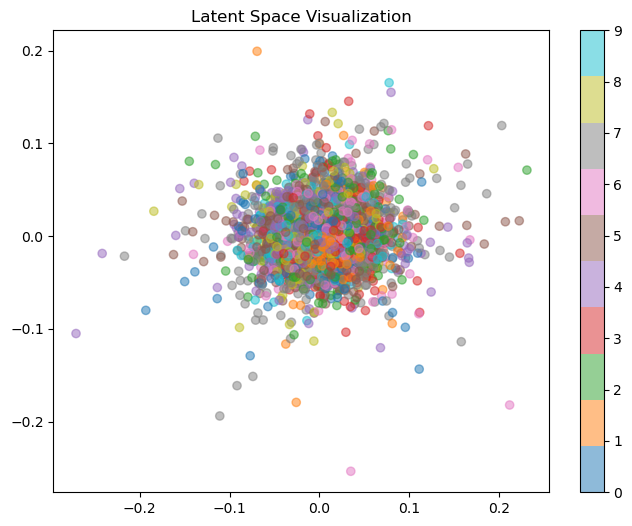

Train Epoch: 1 [0/60000]	Loss: 329.453672
Train Epoch: 1 [10000/60000]	Loss: 141.572969
Train Epoch: 1 [20000/60000]	Loss: 143.740312
Train Epoch: 1 [30000/60000]	Loss: 137.722070
Train Epoch: 1 [40000/60000]	Loss: 136.064316
Train Epoch: 1 [50000/60000]	Loss: 130.781914
====> Epoch: 1 Average loss: 140.0823
Train Epoch: 2 [0/60000]	Loss: 138.889346
Train Epoch: 2 [10000/60000]	Loss: 136.943994
Train Epoch: 2 [20000/60000]	Loss: 135.606387
Train Epoch: 2 [30000/60000]	Loss: 138.032461
Train Epoch: 2 [40000/60000]	Loss: 132.844590
Train Epoch: 2 [50000/60000]	Loss: 129.397949
====> Epoch: 2 Average loss: 134.4922
Train Epoch: 3 [0/60000]	Loss: 127.253281
Train Epoch: 3 [10000/60000]	Loss: 135.279531
Train Epoch: 3 [20000/60000]	Loss: 127.364336
Train Epoch: 3 [30000/60000]	Loss: 137.488311
Train Epoch: 3 [40000/60000]	Loss: 136.608867
Train Epoch: 3 [50000/60000]	Loss: 128.410508
====> Epoch: 3 Average loss: 133.3388
Train Epoch: 4 [0/60000]	Loss: 124.908984
Train Epoch: 4 [10000/60000]

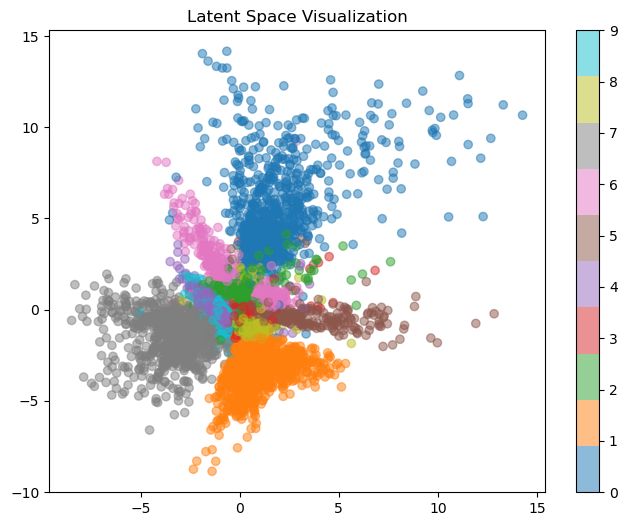

Train Epoch: 1 [0/60000]	Loss: 148.477676
Train Epoch: 1 [10000/60000]	Loss: 147.621689
Train Epoch: 1 [20000/60000]	Loss: 139.682725
Train Epoch: 1 [30000/60000]	Loss: 139.675664
Train Epoch: 1 [40000/60000]	Loss: 139.039229
Train Epoch: 1 [50000/60000]	Loss: 146.282148
====> Epoch: 1 Average loss: 139.1244
Train Epoch: 2 [0/60000]	Loss: 145.644678
Train Epoch: 2 [10000/60000]	Loss: 131.903770
Train Epoch: 2 [20000/60000]	Loss: 148.920898
Train Epoch: 2 [30000/60000]	Loss: 141.359697
Train Epoch: 2 [40000/60000]	Loss: 135.969170
Train Epoch: 2 [50000/60000]	Loss: 134.331055
====> Epoch: 2 Average loss: 138.2098
Train Epoch: 3 [0/60000]	Loss: 141.147295
Train Epoch: 3 [10000/60000]	Loss: 134.564932
Train Epoch: 3 [20000/60000]	Loss: 135.917520
Train Epoch: 3 [30000/60000]	Loss: 135.426045
Train Epoch: 3 [40000/60000]	Loss: 131.061348
Train Epoch: 3 [50000/60000]	Loss: 140.078887
====> Epoch: 3 Average loss: 137.9893
Train Epoch: 4 [0/60000]	Loss: 143.093037
Train Epoch: 4 [10000/60000]

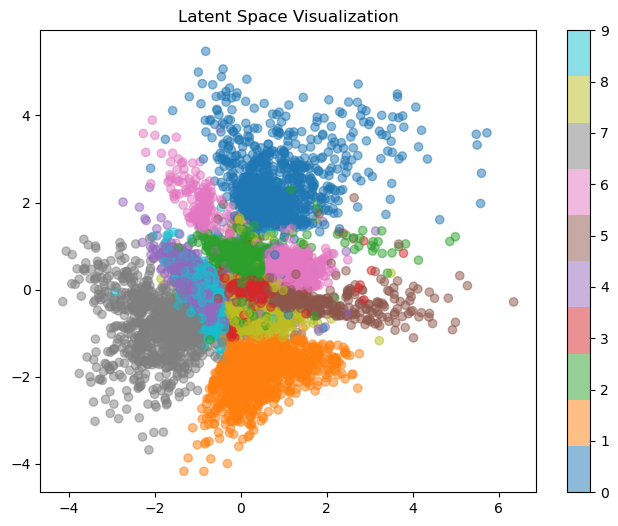

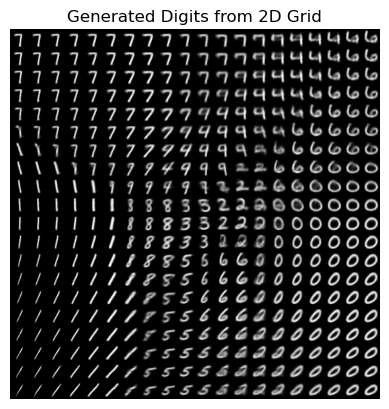

In [5]:
for epoch in range(1, epochs + 1):
    train(epoch)

visualize_latent_space()
sample_and_generate()

# Training without Reconstruction Loss
for epoch in range(1, epochs + 1):
    train(epoch, use_recon_loss=False)
visualize_latent_space()

# Training without KL Divergence Loss
for epoch in range(1, epochs + 1):
    train(epoch, use_kl_loss=False)
visualize_latent_space()

# Training with MSE Loss instead of Binary Cross Entropy
for epoch in range(1, epochs + 1):
    train(epoch)
visualize_latent_space()
sample_and_generate()

# Report

#### Importance of the Reconstruction Loss:
The reconstruction loss is critical because it forces the VAE to learn a latent representation that captures the essential features of the input data. When it is removed, the model only minimizes the KL divergence, which pushes the latent distribution toward the prior.

This results in a latent space that is less informative about the input and leads to poor reconstructions.

#### Grid Visualization Observations:
The grid visualization shows a smooth and continuous transition between different digits. Specific regions of the latent space tend to generate particular digit types, demonstrating that the VAE has learned a well-structured latent representation. Some areas can produce ambiguous or hybrid digits, especially near the boundaries between regions corresponding to different numeral classes.

The observed behavior can be explained by how the reconstruction loss shapes the learned latent space and the network’s tendency to generate “averaged” outputs for ambiguous reconstructions.

- MSE loss calculates the squared differences in pixel intensities, which often pushes the model to produce outputs that align with the mean of uncertain inputs. If the training data contains subtle biases where digits like 9 and 7 share similar average pixel intensity distributions, the model may generate reconstructions that blend features of these digits in certain regions of the latent space.

- BCE loss, being probabilistic, encourages pixel values to be closer to 0 or 1, resulting in sharper and more distinct outputs. This allows the network to better preserve the structural differences between digits rather than averaging their features.

Consequently, when sampling from the MSE-trained VAE’s latent space, digits like 9 and 7 may appear more frequently, as the network’s reconstructions are smoother and influenced by common patterns in the data. In contrast, the BCE-trained model maintains clearer distinctions between different digit classes.